## Load modules

In [1]:
import os
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

## Load and prepare data

In [10]:
df = pd.read_csv('data/auto-mpg.csv', sep=',')
df.columns = [col.strip().replace(' ', '_') for col in df.columns]
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [14]:
df['car_name'] = df['car_name'].apply(lambda x: x.replace('"', ''))

In [20]:
for col in df.columns:
    if col not in ['mpg', 'car_name']:
        df = df[pd.to_numeric(df[col], errors='coerce').notnull()]
        df[col] = df[col].astype(float)
        
X = df.drop(columns=['mpg', 'car_name'])
y = df['mpg']

## Train-Test split

In [21]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=0)

## Conventional way

In [22]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    return rmse, mae

In [23]:
alpha, l1_ratio = 0.01, 0.15

lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
lr.fit(train_X, train_y)

y_pred = lr.predict(test_X)

rmse, mae = eval_metrics(test_y, y_pred)

print(f'Hypermapameters: alpha={alpha}, l1_ratio={l1_ratio}')
print(f'Model Performance on test set:RMSE={rmse}, MAE={mae}')

Hypermapameters: alpha=0.01, l1_ratio=0.15
Model Performance on test set:RMSE=3.264085059242753, MAE=2.4428252673534954


In [24]:
alphas, l1_ratios = [0.01, 0.02, 0.5], [0.15, 0.2, 0.5]

for alpha in alphas:
    for l1_ratio in l1_ratios:
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        lr.fit(train_X, train_y)

        y_pred = lr.predict(test_X)

        rmse, mae = eval_metrics(test_y, y_pred)

        print(f'Hypermapameters: alpha={alpha}, l1_ratio={l1_ratio}')
        print(f'Model Performance on test set:RMSE={rmse}, MAE={mae}')
        print('-'*50, '\n')

Hypermapameters: alpha=0.01, l1_ratio=0.15
Model Performance on test set:RMSE=3.264085059242753, MAE=2.4428252673534954
-------------------------------------------------- 

Hypermapameters: alpha=0.01, l1_ratio=0.2
Model Performance on test set:RMSE=3.2641081943690287, MAE=2.442779799335202
-------------------------------------------------- 

Hypermapameters: alpha=0.01, l1_ratio=0.5
Model Performance on test set:RMSE=3.2642539363043768, MAE=2.4425053728576818
-------------------------------------------------- 

Hypermapameters: alpha=0.02, l1_ratio=0.15
Model Performance on test set:RMSE=3.268230661826571, MAE=2.4462236246381988
-------------------------------------------------- 

Hypermapameters: alpha=0.02, l1_ratio=0.2
Model Performance on test set:RMSE=3.2682901197277037, MAE=2.4461431101781237
-------------------------------------------------- 

Hypermapameters: alpha=0.02, l1_ratio=0.5
Model Performance on test set:RMSE=3.268674967967474, MAE=2.4456545533936795
-----------------

## Using mlflow

In [25]:
experiment_name = 'PlainRegression'

try:
    exp_id = mlflow.create_experiment(name=experiment_name)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

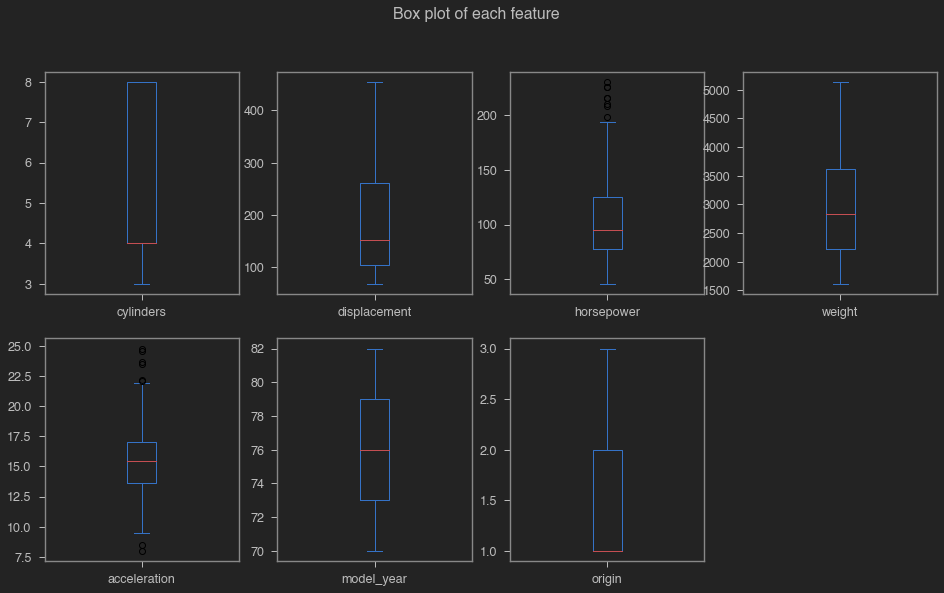

In [27]:
if 'images' not in os.listdir():
    os.makedirs('images')
    
with mlflow.start_run(experiment_id=exp_id):
    train_X.plot(kind='box', subplots=True, layout=(2,4), figsize=(16,9), title='Box plot of each feature')
    plt.savefig('images/distribution_plot_all_features.png')
    
    mlflow.log_artifacts('images')
    
    alpha, l1_ratio = 0.01, 0.15

    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_X, train_y)

    y_pred = lr.predict(test_X)

    rmse, mae = eval_metrics(test_y, y_pred)

    mlflow.log_param('alpha',  alpha)
    mlflow.log_param('l1_ratio', l1_ratio)
    
    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('mae', mae)
    
    mlflow.sklearn.log_model(lr, 'PlainRegressionModel')